<a href="https://colab.research.google.com/github/sheldonkemper/bank_of_england/blob/main/notebooks/modelling/ob_flan_t5_sentiment_jpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
===================================================
Author: Oscar Bowden
Role: Research Lead, Bank of England Employer Project (Quant Collective)
LinkedIn: https://uk.linkedin.com/in/oscar-bowden-4b14711b7
Date: 2025-03-05
Version: 2.4

Description:
    This notebook contains an inference pipeline for a Flan-T5 (base)
    model that has been fine-tuned for polar sentiment analysis
    of financial sentences (using Financial Phrasebank:
    https://huggingface.co/datasets/takala/financial_phrasebank).
===================================================
"""

'\n===================================================\nAuthor: Oscar Bowden\nRole: Research Lead, Bank of England Employer Project (Quant Collective)\nLinkedIn: https://uk.linkedin.com/in/oscar-bowden-4b14711b7\nDate: 2025-03-05\nVersion: 2.4\n\nDescription:\n    This notebook contains an inference pipeline for a Flan-T5 (base)\n    model that has been fine-tuned for polar sentiment analysis\n    of financial sentences (using Financial Phrasebank:\n    https://huggingface.co/datasets/takala/financial_phrasebank).\n===================================================\n'

# Imports

In [2]:
!pip install -q transformers torch datasets scikit-learn > /dev/null 2>&1

In [3]:
#Imports

# Mount Google Drive
from google.colab import drive
import os

# Data handling
import re
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Fine-Tuning approach

In [4]:
print(f"\nThe Financial Phrasebank (https://huggingface.co/datasets/takala/financial_phrasebank) subset with full annotator agreement (sentences_allagree) was used to fine-tune Flan-T5.")

The Financial Phrasebank (https://huggingface.co/datasets/takala/financial_phrasebank) subset with full annotator agreement (sentences_allagree) was used to fine-tune Flan-T5.


In [6]:
print(f"\nFull model training and validation code is not included as to limit compute wastage, but is available here: https://colab.research.google.com/drive/12UEZSQF1YWwJ_Knv1x8vBiadC5xCRDRF?usp=sharing")

Full model training and validation code is not included as to limit compute wastage, but is available here: https://colab.research.google.com/drive/12UEZSQF1YWwJ_Knv1x8vBiadC5xCRDRF?usp=sharing


In [7]:
print(f"\nThe resultant best model is used below to infer for our pipeline.")


The resultant best model is used below to infer for our pipeline.


# Data loading and pre-processing

In [9]:
# Load topic modelled data (questions and answers for JPM and UBS)

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [10]:
path1 = "/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/Topic_Modelling_am/tqc_JPMorgan_answer_topic.csv"
path2 = "/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/Topic_Modelling_am/tqc_UBS_answer_topic.csv"
path3 = "/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/Topic_Modelling_am/tqc_JPMorgan_question_topic.csv"
path4 = "/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/Topic_Modelling_am/tqc_UBS_question_topic.csv"


df_a_jpm = pd.read_csv(path1)
df_a_ubs = pd.read_csv(path2)
df_q_jpm = pd.read_csv(path3)
df_q_ubs = pd.read_csv(path4)

In [11]:
#Cleaning - remove quotes

df_a_jpm['Snippet'] = df_a_jpm['Snippet'].str.replace('"', '', regex=False)
df_a_ubs['Snippet'] = df_a_ubs['Snippet'].str.replace('"', '', regex=False)

df_q_jpm['Snippet'] = df_q_jpm['Snippet'].str.replace('"', '', regex=False)
df_q_ubs['Snippet'] = df_q_ubs['Snippet'].str.replace('"', '', regex=False)

In [12]:
#Prepare topics for input into fine-tuned flan-t5

def prepare_text_for_inference(text):
    text = str(text).strip()
    return f"Classify sentiment: {text}"

df_a_jpm["snippet_infer"] = df_a_jpm["Snippet"].apply(prepare_text_for_inference)
df_a_ubs["snippet_infer"] = df_a_ubs["Snippet"].apply(prepare_text_for_inference)

df_q_jpm["snippet_infer"] = df_q_jpm["Snippet"].apply(prepare_text_for_inference)
df_q_ubs["snippet_infer"] = df_q_ubs["Snippet"].apply(prepare_text_for_inference)

# Inference on topic snippets using fine-tuned Flan-T5

In [13]:
# Load fine-tuned model and tokeniser from the best checkpoint

best_checkpoint = "/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/flan_t5_sent"

model = T5ForConditionalGeneration.from_pretrained(best_checkpoint)
tokenizer = T5Tokenizer.from_pretrained(best_checkpoint)

# Define the prediction function using your fine-tuned model
def predict_sentiment(prepared_text):
    """
    Predicts sentiment using the fine-tuned Flan-T5 model.
    Assumes the input text is already preprocessed (i.e., prompt prepended).
    """
    inputs = tokenizer(prepared_text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=2)
    return tokenizer.decode(output[0], skip_special_tokens=True).strip()

# Apply inference on your prepared quarterly data
df_a_jpm["snippet_sent"] = df_a_jpm["snippet_infer"].apply(predict_sentiment)
df_a_ubs["snippet_sent"] = df_a_ubs["snippet_infer"].apply(predict_sentiment)

df_q_jpm["snippet_sent"] = df_q_jpm["snippet_infer"].apply(predict_sentiment)
df_q_ubs["snippet_sent"] = df_q_ubs["snippet_infer"].apply(predict_sentiment)

In [14]:
df_a_jpm["snippet_sent"] = df_a_jpm["snippet_sent"].map({"0": "Negative", "1": "Neutral", "2": "Positive"})
df_a_ubs["snippet_sent"] = df_a_ubs["snippet_sent"].map({"0": "Negative", "1": "Neutral", "2": "Positive"})

df_a_jpm.drop(columns=['snippet_infer'], inplace=True)
df_a_ubs.drop(columns=['snippet_infer'], inplace=True)

df_q_jpm["snippet_sent"] = df_q_jpm["snippet_sent"].map({"0": "Negative", "1": "Neutral", "2": "Positive"})
df_q_ubs["snippet_sent"] = df_q_ubs["snippet_sent"].map({"0": "Negative", "1": "Neutral", "2": "Positive"})

df_q_jpm.drop(columns=['snippet_infer'], inplace=True)
df_q_ubs.drop(columns=['snippet_infer'], inplace=True)

In [ ]:
print(f"\nResulting polar sentiment counts for JPM and UBS topic snippets across 'question' and 'answer' transcript segments are shown below.")

In [15]:
print(f"JPM Answer Snippet Sentiment:\n {df_a_jpm['snippet_sent'].value_counts()}")
print(f"\nUBS Answer Snippet Sentiment:\n {df_a_ubs['snippet_sent'].value_counts()}")

print(f"\nJPM Question Snippet Sentiment:\n {df_q_jpm['snippet_sent'].value_counts()}")
print(f"\nUBS Question Snippet Sentiment:\n {df_q_ubs['snippet_sent'].value_counts()}")

JPM Answer Snippet Sentiment:
 snippet_sent
Neutral     335
Positive     81
Negative     18
Name: count, dtype: int64

UBS Answer Snippet Sentiment:
 snippet_sent
Neutral     268
Positive     69
Negative     20
Name: count, dtype: int64

JPM Question Snippet Sentiment:
 snippet_sent
Neutral     311
Positive     64
Negative     12
Name: count, dtype: int64

UBS Question Snippet Sentiment:
 snippet_sent
Neutral     370
Positive     93
Negative     13
Name: count, dtype: int64


In [16]:
#Save CSVs

file_path_1 = "/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/sent_output/JPM_answers_sent_output_050325_v1.csv"
file_path_2 = "/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/sent_output/UBS_answers_sent_output_050325_v1.csv"
file_path_3 = "/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/sent_output/JPM_questions_sent_output_050325_v1.csv"
file_path_4 = "/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/sent_output/UBS_questions_sent_output_050325_v1.csv"

df_a_jpm.to_csv(file_path_1, index=False)

df_a_ubs.to_csv(file_path_2, index=False)

df_q_jpm.to_csv(file_path_3, index=False)

df_q_ubs.to_csv(file_path_4, index=False)

In [17]:
print(f"\nBar plot to show sentiment proportions:\n")

Bar plot to show sentiment proportions across JPM and UBS analyst questions, and executive answers topic snippets



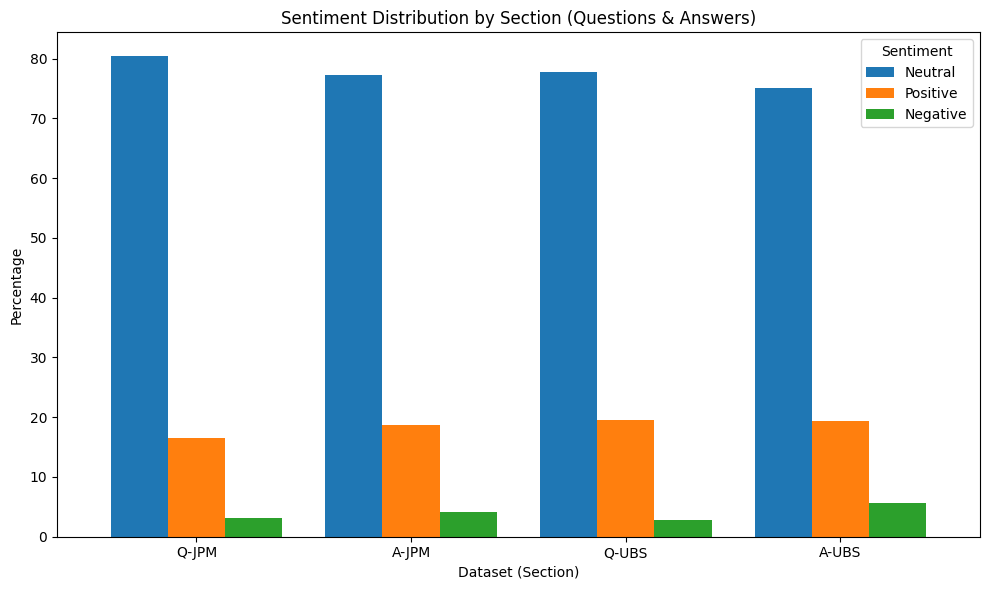

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the datasets and corresponding labels
dataframes = {
    "Q-JPM": df_q_jpm,
    "A-JPM": df_a_jpm,
    "Q-UBS": df_q_ubs,
    "A-UBS": df_a_ubs
}

# Define sentiment categories
sentiments = ["Neutral", "Positive", "Negative"]

# Compute sentiment distributions for each dataset
sentiment_counts = {}

for name, df in dataframes.items():
    counts = df["snippet_sent"].value_counts(normalize=True) * 100  # Convert to percentage
    sentiment_counts[name] = [counts.get(sent, 0) for sent in sentiments]

# Convert to DataFrame for plotting
sentiment_df = pd.DataFrame(sentiment_counts, index=sentiments)

# Plot bar chart
ax = sentiment_df.T.plot(kind="bar", figsize=(10,6), width=0.8)

plt.xlabel("Dataset (Section)")
plt.ylabel("Percentage")
plt.title("Sentiment Distribution by Section (Questions & Answers)")
plt.legend(title="Sentiment")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [19]:
print(f"Line plot to show average sentiment score (calculated according to: Negative: 0, Neutral: 1, Positive: 2):\n")

Line plot to show average sentiment score (calculated according to: Negative: 0, Neutral: 1, Positive: 2) across JPM and UBS analyst questions, and executive answers topic snippets



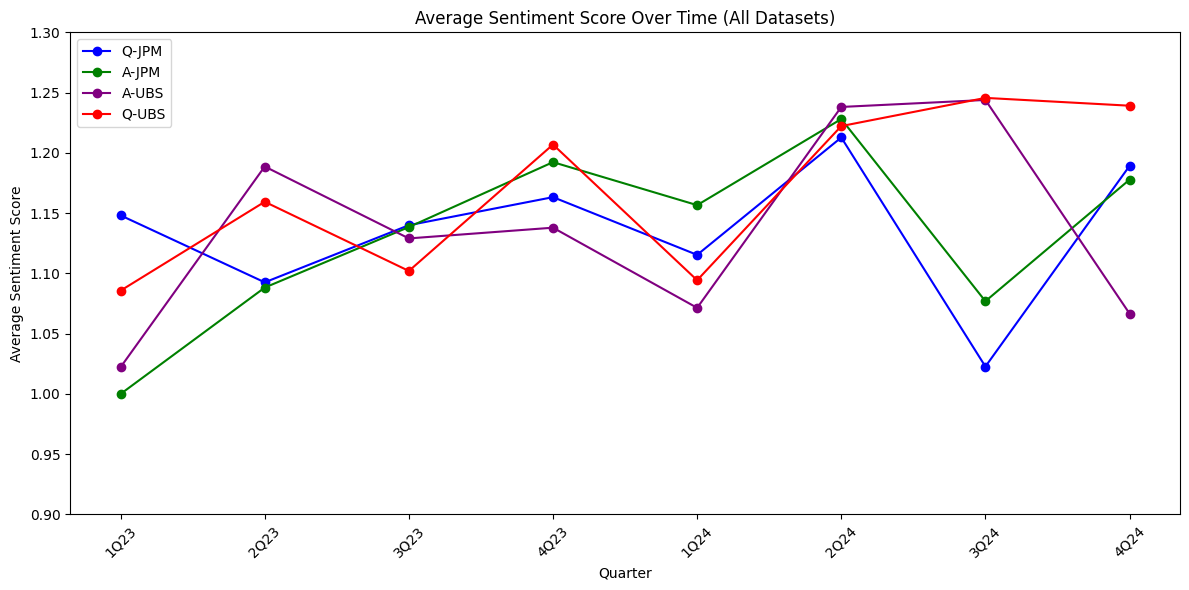

In [20]:
import matplotlib.pyplot as plt
import re

# Function to extract and sort Quarter-Year correctly
def extract_year_quarter(q):
    m = re.match(r"(\d)Q(\d+)", q)
    if m:
        quarter = int(m.group(1))
        year = int(m.group(2))
        return (year, quarter)
    else:
        return (9999, 99)  # Fallback if format doesn't match

# Define sentiment mapping (Numerical Scores)
sentiment_map = {"Negative": 0, "Neutral": 1, "Positive": 2}

# List of dataframes and their names
dataframes = {
    "Q-JPM": df_q_jpm,
    "A-JPM": df_a_jpm,
    "A-UBS": df_a_ubs,
    "Q-UBS": df_q_ubs
}

# Initialize dictionary to store average sentiment scores over time
avg_sentiment_scores = {}

# Process each dataframe
for name, df in dataframes.items():
    # Convert sentiment labels to numerical scores
    df["sentiment_score"] = df["snippet_sent"].map(sentiment_map)

    # Compute average sentiment per quarter
    avg_scores = df.groupby("Quarter")["sentiment_score"].mean()

    # Sort by quarter using extract_year_quarter function
    sorted_quarters = sorted(avg_scores.index, key=extract_year_quarter)
    avg_sentiment_scores[name] = avg_scores.reindex(sorted_quarters)

# Plot average sentiment trends for all datasets
plt.figure(figsize=(12, 6))

# Define colors for better distinction
colors = {
    "Q-JPM": "blue",
    "A-JPM": "green",
    "A-UBS": "purple",
    "Q-UBS": "red"
}

# Plot average sentiment score for each dataset
for name, scores in avg_sentiment_scores.items():
    quarters = scores.index
    plt.plot(quarters, scores, marker='o', label=name, color=colors[name])

plt.xlabel("Quarter")
plt.ylabel("Average Sentiment Score")
plt.title("Average Sentiment Score Over Time (All Datasets)")
plt.xticks(rotation=45)
plt.ylim(0.9, 1.3)  # Since scores range from 0 (Negative) to 2 (Positive)
plt.legend()
plt.tight_layout()
plt.show()

# Fine-tuned Flan-T5 and FinBERT comparison: ground-truth labelled JPM answer topic snippet data

In [21]:
print("Topic snippets from 3Q24 and 4Q24 were manually ground-labelled with polar sentiment. The sentiment extraction performance of fine-tuned Flan-T5 and FinBERT using this data as a benchmark is shown below.")

Topic snippets from 3Q24 and 4Q24 were manually ground-labelled with polar sentiment. The sentiment extraction performance of fine-tuned Flan-T5 and FinBERT using this data as a benchmark is shown below.


In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load FinBERT model & tokenizer
finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# Function to predict sentiment using FinBERT
def predict_finbert_sentiment(text):
    inputs = finbert_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = finbert_model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_labels = ["Negative", "Neutral", "Positive"]
    return sentiment_labels[scores.argmax().item()]

# List of datasets
dataframes = {
    "df_a_jpm": df_a_jpm,
}

# Run FinBERT on all datasets
for name, df in dataframes.items():
    df["finbert_sentiment"] = df["Snippet"].apply(predict_finbert_sentiment)

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [23]:
print(f"Fine-tuned Flan-T5 JPM Answer Snippet Sentiment:\n {df_a_jpm['snippet_sent'].value_counts()}")
print(f"\nFinBERT JPM Answer Snippet Sentiment:\n {df_a_jpm['finbert_sentiment'].value_counts()}")

Fine-tuned Flan-T5 JPM Answer Snippet Sentiment:
 snippet_sent
Neutral     335
Positive     81
Negative     18
Name: count, dtype: int64

FinBERT JPM Answer Snippet Sentiment:
 finbert_sentiment
Positive    283
Negative     96
Neutral      56
Name: count, dtype: int64


In [25]:
file_path = "/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/sent_output/ground_labeled_3q_4q_24_JPM_answer_snippets.csv"
ground_labelled = pd.read_csv(file_path)

ground_labelled = pd.DataFrame(ground_labelled)

In [ ]:
print(f"\nBar plot to show sentiment proportions. Ground-truth vs Fine-Tuned Flan-T5 vs FinBERT")

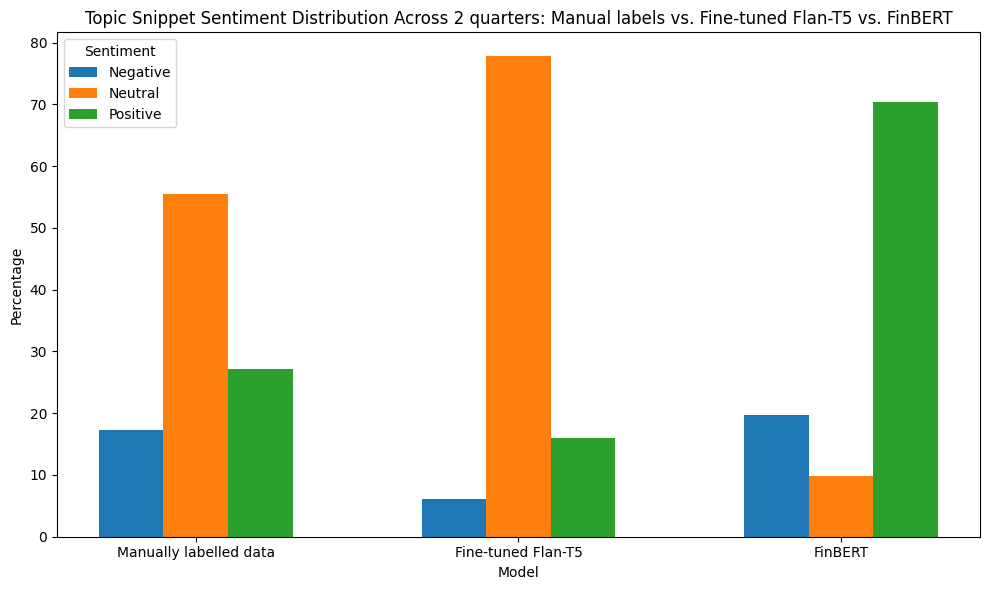

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define sentiment categories
sentiments = ["Negative", "Neutral", "Positive"]

# Compute sentiment proportions for each method
datasets = {
    "Manually labelled data": ground_labelled["manual_label"],
    "Fine-tuned Flan-T5": ground_labelled["snippet_sent"],
    "FinBERT": ground_labelled["finbert_sentiment"]
}

# Create a DataFrame to store proportions
sentiment_proportions = {}

for name, labels in datasets.items():
    counts = labels.value_counts(normalize=True) * 100  # Convert to percentage
    sentiment_proportions[name] = [counts.get(sent, 0) for sent in sentiments]

# Convert to DataFrame for plotting
sentiment_df = pd.DataFrame(sentiment_proportions, index=sentiments)

# Plot grouped bar chart (3 bars per model)
fig, ax = plt.subplots(figsize=(10,6))
bar_width = 0.2  # Width of individual bars
x = np.arange(len(datasets))  # X-axis positions for each group

# Plot bars for each sentiment
for i, sentiment in enumerate(sentiments):
    ax.bar(x + i * bar_width, sentiment_df.loc[sentiment], width=bar_width, label=sentiment)

# Formatting
ax.set_xlabel("Model")
ax.set_ylabel("Percentage")
ax.set_title("Topic Snippet Sentiment Distribution Across 2 quarters: Manual labels vs. Fine-tuned Flan-T5 vs. FinBERT")
ax.set_xticks(x + bar_width)
ax.set_xticklabels(datasets.keys())  # Labels for each dataset (model)
ax.legend(title="Sentiment")
plt.tight_layout()
plt.show()

In [ ]:
print(f"\nMetrics for the Flan-T5 and FinBERT comparison:")

In [27]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Define the target names in the expected order
target_names = ["Negative", "Neutral", "Positive"]

# Ensure all labels are string types to avoid classification errors
ground_labelled["manual_label"] = ground_labelled["manual_label"].astype(str)
ground_labelled["snippet_sent"] = ground_labelled["snippet_sent"].astype(str)
ground_labelled["finbert_sentiment"] = ground_labelled["finbert_sentiment"].astype(str)

# ----------------------------
# Metrics for Fine-Tuned Flan-T5 Model
# ----------------------------
accuracy_t5 = accuracy_score(ground_labelled["manual_label"], ground_labelled["snippet_sent"])
f1_t5 = f1_score(ground_labelled["manual_label"], ground_labelled["snippet_sent"], average="weighted")
report_t5 = classification_report(ground_labelled["manual_label"], ground_labelled["snippet_sent"], target_names=target_names)

print("\n Fine-Tuned Flan-T5 Model Metrics:")
print("Accuracy:", round(accuracy_t5, 4))
print("Weighted F1:", round(f1_t5, 4))
print("Classification Report:\n", report_t5)

# ----------------------------
# Metrics for FinBERT Model
# ----------------------------
accuracy_finbert = accuracy_score(ground_labelled["manual_label"], ground_labelled["finbert_sentiment"])
f1_finbert = f1_score(ground_labelled["manual_label"], ground_labelled["finbert_sentiment"], average="weighted")
report_finbert = classification_report(ground_labelled["manual_label"], ground_labelled["finbert_sentiment"], target_names=target_names)

print("\n FinBERT Model Metrics:")
print("Accuracy:", round(accuracy_finbert, 4))
print("Weighted F1:", round(f1_finbert, 4))
print("Classification Report:\n", report_finbert)


 Fine-Tuned Flan-T5 Model Metrics:
Accuracy: 0.7778
Weighted F1: 0.7557
Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.36      0.53        14
     Neutral       0.71      1.00      0.83        45
    Positive       1.00      0.59      0.74        22

    accuracy                           0.78        81
   macro avg       0.90      0.65      0.70        81
weighted avg       0.84      0.78      0.76        81


 FinBERT Model Metrics:
Accuracy: 0.1728
Weighted F1: 0.1102
Classification Report:
               precision    recall  f1-score   support

    Negative       0.19      0.21      0.20        14
     Neutral       0.00      0.00      0.00        45
    Positive       0.19      0.50      0.28        22

    accuracy                           0.17        81
   macro avg       0.13      0.24      0.16        81
weighted avg       0.08      0.17      0.11        81

